# import 

In [1]:
from scipy.spatial.distance import pdist, squareform

from numpy import linalg as LA

from scipy.linalg import eigh, eig 

import numpy as np 
import numpy 
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt 
from cvxopt import matrix 
import cvxopt 
import numpy 
%matplotlib inline 

# 问题    

## 转化为 qp 


\begin{align}
\max & \sum_{i} \alpha_{i}<v_i,y >_{F}^2 - \lambda ( \sum_{i}\alpha_{i}^2 -1 ) \\
st. & \quad \alpha_{i} \geq 0 \quad  \forall i   \\
\end{align}
为什么令 核对齐的分母等于常数？ 
为什么 $\lambda $ 也可以为常数？ 

\begin{align}
\min &   \sum_{i}\alpha_{i}^2   -  \sum_{i} \alpha_{i}<v_i,y >_{F}^2 \\
st. &  \quad \alpha_{i} \geq 0 \forall i   \\
\end{align}

上面优化问题可以化为二次规划问题： 
\begin{align}
 \min & \quad     \alpha^T  I_p \alpha  + b^T\alpha \\
 st. & \quad -\alpha  \leq 0    
\end{align}
where $I_p$ is identity matrix, $p$ is the number of eigen vectors, $\alpha=(\alpha_1, ..., \alpha_p)$, $b =-(<v_1,y >_{F}^2, ..., <v_p,y >_{F}^2)$

对比 二次规划的标准形式： 
\begin{align}
 \min & \quad    1/2  x^T  P x  +  q^T x \\
 st. & \quad Gx  \preccurlyeq h     \\
\end{align}
需要四个输入 (P, q, G, h)
对应的， 四个值分别是 
\begin{align*} 
P &=   2I_p \\ 
q &= b \\ 
G &=  -I_p \\ 
h &=  \mathbf{0}  \\
x &=  \alpha  \\ 
\end{align*}

## qp solover 

In [2]:
def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    #print ( "G::: ")
    #print ( G )
    args = [cvxopt.matrix(P,tc="d"), cvxopt.matrix(q,  tc="d")]
    
    if G is not None:
        args.extend([cvxopt.matrix(G,tc="d"), cvxopt.matrix(h,tc="d")])
        if A is not None:
            args.extend([cvxopt.matrix(A,tc="d"), cvxopt.matrix(b,tc="d" )])
    print  ( args  )
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return numpy.array(sol['x']).reshape((P.shape[1],))

In [3]:
# alpha = cvxopt_solve_qp(P, q, G, h)   

#  例子 

## data create 

(100, 2)


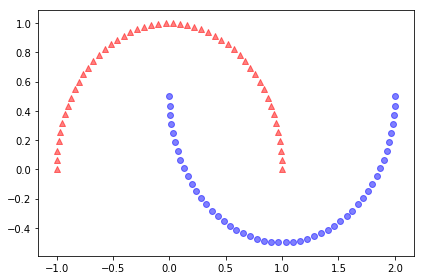

In [4]:

X, y = make_moons(n_samples=100, random_state=123)
print (X.shape )
plt.scatter(X[y==0, 0], X[y==0, 1],color='red', marker='^', alpha=0.5)

plt.scatter(X[y==1, 0], X[y==1, 1],color='blue', marker='o', alpha=0.5)

plt.tight_layout()

plt.show()

##  得到 P q G, h 
\begin{align*} 
P &=   2I_p \\ 
q &= b \\ 
G &=  -I_p \\ 
h &=  \mathbf{0}  \\
x &=  \alpha  \\ 
\end{align*}

In [7]:
p=5 # 取前五个 eigen vector 
P = 2* np.eye(p)
G = -1* np.eye(p) 
h= np.zeros( p )


##  得到 b :   $b =-(<v_1,y >_{F}^2, ..., <v_p,y >_{F}^2)$

###   定义 提取  p 个  kernel eigen vectors 

In [8]:
def rbf_kernel_eigen_vectors(X, gamma, centered = False ,n_components =3   ):

    """
    RBF kernel return eigen values and vectors    

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]  

    gamma: float  

        Tuning parameter of the RBF kernel    

    n_components: int
        Number of  larger eigen

    Returns
    ------------
    X_eigen: {NumPy ndarray}, shape = [n_examples, k_features]

        top-k eigen vectors       

    """
    #### 1  K = Kernel matrix 

    #dist_condensed = pdist(X , lambda u, v: np.exp(  -(((u-v)**2).sum()) / 2*gamma*gamma  ) )
    #dist_X  = squareform(dist_condensed) 
    #pairwise_dists = squareform(pdist(X, 'euclidean'))
    #K = np.exp(-pairwise_dists ** 2 / gamma  ** 2)
    pairwise_sq_dists = squareform(pdist(X, 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / gamma **2)
    #print ( K.shape   )
    #print ( K )
    
    if centered :
        #   zero mean  of the kernel matrix.

        N = K.shape[0]
        one_n = np.ones((N,N)) / N
    
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)    
    
    
    # compute eigen vector of K 
    
    eigvals, eigvecs = eigh(K)  
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
#     sort_vals = True 
#     if sort_vals:
#         idx = eigvals.argsort()[::-1]  
#         print ( idx )
#         asdf 
#         eigvals = eigvals[idx]
#         eigvecs = eigvecs[:,idx]
    #print ( eigvals )
    #print (   ( eigvals  ))
#     print ( len  ([e   for e in  eigvals if e >0    ]))
#     print ( eigvecs.shape )
#     print ( np.sum(eigvals > 1e-10) )
#     print ( numpy.linalg.matrix_rank(  K  ) )
    #n_components =4 
    # select top-k , get k*N matrx   W 
    X_eigen = np.column_stack([eigvecs[:, i]
                           for i in range(n_components)])    

    #print ( X_eigen.shape )    
      
    return X_eigen 
    

In [9]:
#p= 5  # 
X_eigen = rbf_kernel_eigen_vectors(X, gamma=15,n_components=p  ) 
X_eigen.shape  


(100, 5)

### 得到b     $b =-(<v_1,y >_{F}^2, ..., <v_p,y >_{F}^2)= - (y^T*[v_1, ...,v_p])^2$

In [10]:
y.shape 

(100,)

In [11]:
b= np.matmul(y.reshape(-1,1 ).T, X_eigen)

In [12]:
b = np.matmul(y.reshape(-1,1 ).T,X_eigen)**2 
b 

array([[2.49997399e+01, 1.06292427e+01, 5.65680116e+00, 2.42510316e-04,
        7.82792293e-06]])

In [13]:
b= -1*b 
b 

array([[-2.49997399e+01, -1.06292427e+01, -5.65680116e+00,
        -2.42510316e-04, -7.82792293e-06]])

In [14]:
q = b.reshape(-1,1 )
q.shape 

(5, 1)

## 运行 

In [16]:
for e in [P , q,G, h ]:
    print  (e.shape )

(5, 5)
(5, 1)
(5, 5)
(5,)


In [15]:
P , q,G, h  

(array([[2., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0.],
        [0., 0., 2., 0., 0.],
        [0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 2.]]), array([[-2.49997399e+01],
        [-1.06292427e+01],
        [-5.65680116e+00],
        [-2.42510316e-04],
        [-7.82792293e-06]]), array([[-1., -0., -0., -0., -0.],
        [-0., -1., -0., -0., -0.],
        [-0., -0., -1., -0., -0.],
        [-0., -0., -0., -1., -0.],
        [-0., -0., -0., -0., -1.]]), array([0., 0., 0., 0., 0.]))

In [18]:
# alpha = cvxopt_solve_qp(P, q, G, h)   
alpha_result = cvxopt_solve_qp(P, q, G, h)   
alpha_result

[<5x5 matrix, tc='d'>, <5x1 matrix, tc='d'>, <5x5 matrix, tc='d'>, <5x1 matrix, tc='d'>]
     pcost       dcost       gap    pres   dres
 0: -1.7110e+02 -2.1400e+02  4e+01  0e+00  8e-01
 1: -1.9204e+02 -1.9629e+02  4e+00  2e-15  8e-02
 2: -1.9249e+02 -1.9255e+02  6e-02  2e-15  7e-04
 3: -1.9249e+02 -1.9249e+02  6e-04  2e-15  7e-06
 4: -1.9249e+02 -1.9249e+02  9e-06  4e-15  7e-08
Optimal solution found.


array([1.24998696e+01, 5.31462106e+00, 2.82840032e+00, 9.27998435e-04,
       8.64969295e-04])

# 得到Kernel  

In [37]:
X_eigen.shape  , alpha_result.shape  

((100, 5), (5,))

In [43]:
kernel_list =  [np.outer( X_eigen[:,i], X_eigen[:,i] ) for i in range(p  )] 

In [40]:
#X_eigen*(alpha_result.reshape(-1,1 ))  
#np.matmul(X_eigen, alpha_result.reshape(-1,1 )) 

In [46]:
kernel_final= np.array(  sum ([ w*v for w,v in zip( alpha_result ,  kernel_list  )]))
kernel_final 

array([[0.14963482, 0.10054673, 0.12885322, ..., 0.15371032, 0.16395768,
        0.09740576],
       [0.10054673, 0.19533243, 0.18517619, ..., 0.06232447, 0.13850402,
        0.18591372],
       [0.12885322, 0.18517619, 0.21988225, ..., 0.07954137, 0.2119987 ,
        0.16558089],
       ...,
       [0.15371032, 0.06232447, 0.07954137, ..., 0.18477015, 0.12769719,
        0.06870884],
       [0.16395768, 0.13850402, 0.2119987 , ..., 0.12769719, 0.25891092,
        0.11667637],
       [0.09740576, 0.18591372, 0.16558089, ..., 0.06870884, 0.11667637,
        0.18083406]])